# ECE 5973 - Computer Vision
## Progress Report
### Sarah Brown

#### Project Overview
My goal for the final project is to be able to process a video stream of dice rolling into a tray to be able to display and sum the result. The dice of concern are a standard 7 polyhedral dice set.

My goals for this progress report were:
* Collect test images
* Filter images to dice
* Identify die type based on shape
* Investigate packages to use to detect text on dice

#### Project so far
So far in this project I have managed to filter to the dice in a couple of different ways. The most effective way to filter to the die is with a CSV mask. This can be seen in the chunk below with a blue d12 die.

(<matplotlib.image.AxesImage at 0x7f03674efee0>, ([], []), ([], []))

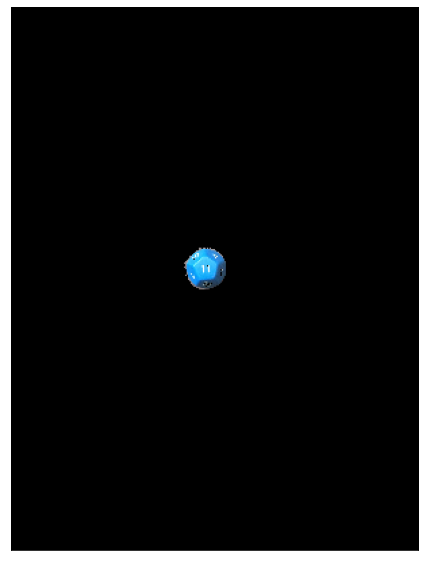

In [1]:
from cv2 import cv2
import numpy as np
import imutils
from matplotlib import pyplot as plt
import cvui
%matplotlib inline

img = cv2.imread('/home/stars/Documents/CV/Final Project/testPics/test (2).jpg')
img = cv2.resize(img, (0,0), fx=0.1, fy=0.1) 

lower = np.array([89,0,0])
upper = np.array([179,255,255])

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, lower, upper)

applyMask = cv2.bitwise_and(img, img, mask=mask)
applyMaskRGB = cv2.cvtColor(applyMask, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(applyMaskRGB), plt.xticks([]), plt.yticks([])

However, this type of filtering can have issues depending on the lighting and needs to be adjusted depending on the color of the die. 

I wanted to try and have a filter that was applicable no matter the lighting or die type. However, this has proven to be challenging and still needs improvement. Currently I have it so I can identify a d12 or a d6 from a still image. This can be seen in the chunk below. 

I applied the filter and identifying method seen in the chunk below to a realtime video stream. This had mixed results as it was constantly updating. I plan to change this so that it only updates if there is movement in the frame. As the webcam I am currently using has random autofocus this may be challenging.

In [4]:
def detectShape(c):          
       shape = 'unknown' 
       peri=cv2.arcLength(c,True) 
       vertices = cv2.approxPolyDP(c, 0.02 * peri, True)
       sides = len(vertices) 
       if (sides == 3): 
            shape='triangle' 
       elif(sides==4): 
             x,y,w,h=cv2.boundingRect(c)
             aspectratio=float(w)/h 
             if (aspectratio==1):
                   shape='d6'
             else:
                   shape="d6" 
       elif(sides==7): 
            shape='d12' 
       else:
           shape='circle' 
       return shape 

def dieShape(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgNoise = cv2.medianBlur(imgGray,3)
    imgBlur = cv2.GaussianBlur(imgNoise,(3,3),0)
    imgCanny = cv2.Canny(imgBlur, 0, 255)

    cnts = cv2.findContours(imgCanny.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    ret,thresh = cv2.threshold(imgCanny,200,225,1)
    contours,h = cv2.findContours(thresh,1,2)

    firstPass = img.copy()

    for cnt in cnts:
        if cv2.arcLength(cnt,False) > 0 and cv2.arcLength(cnt,False) < 300:
            accuracy = 0.03*cv2.arcLength(cnt,True)
            approx = cv2.approxPolyDP(cnt, accuracy, True)

            moment=cv2.moments(approx) 
            if moment["m00"] != 0:
                cx = int(moment['m10'] / moment['m00']) 
                cy = int(moment['m01'] / moment['m00'])
            else:
                cx = 0
                cy = 0
            shape=detectShape(approx) 
            cv2.drawContours(firstPass,[approx],-1,(0,255,0),2)
            cv2.putText(firstPass,shape,(cx,cy),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),2)

    return(firstPass)

d12 = cv2.imread("/home/stars/Documents/CV/Final Project/testPics/test (16).jpg")
d6 = cv2.imread("/home/stars/Documents/CV/Final Project/testPics/test (17).jpg")
d12Type = dieShape(d12)
d6Type = dieShape(d6)

(<AxesSubplot:title={'center':'d6 Type'}>,
 Text(0.5, 1.0, 'd6 Type'),
 ([], []),
 ([], []))

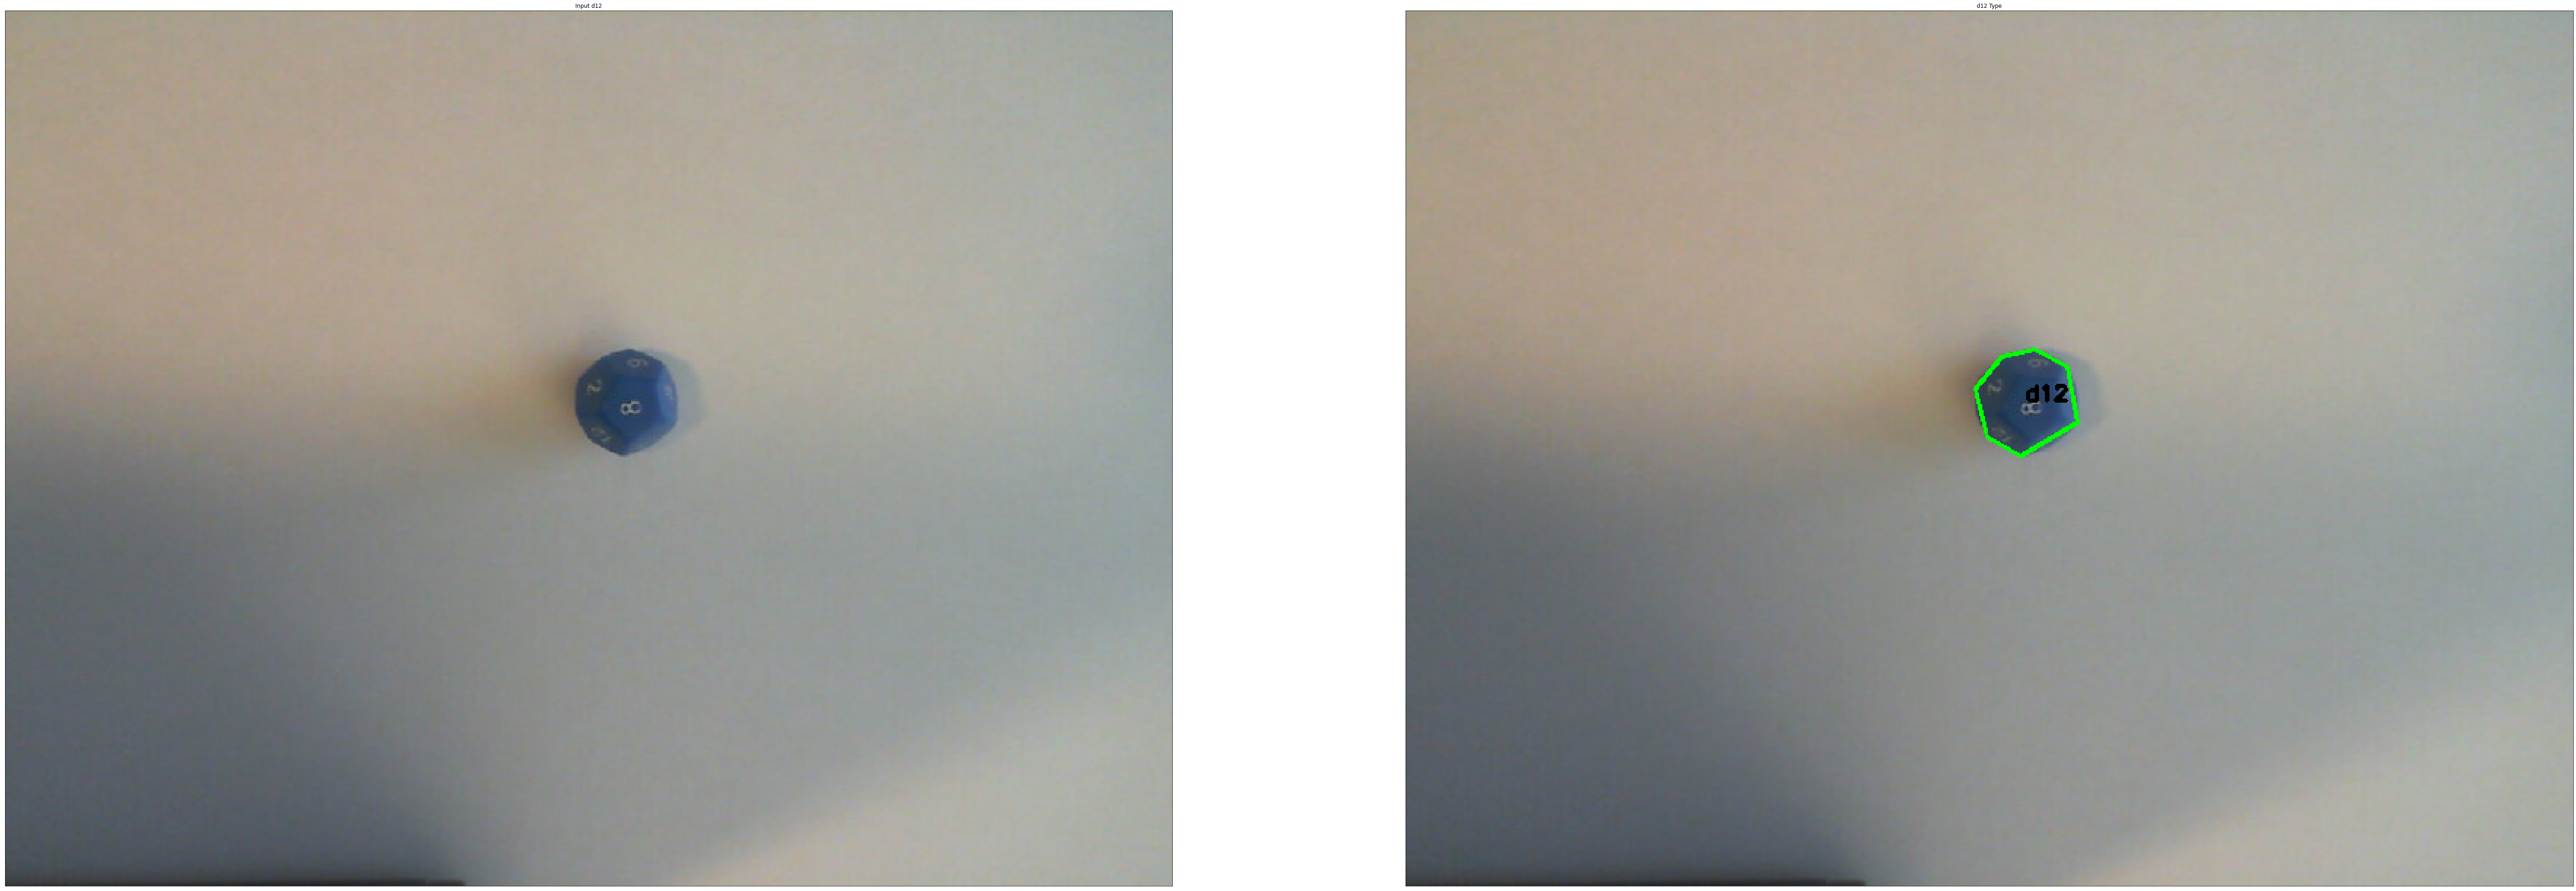

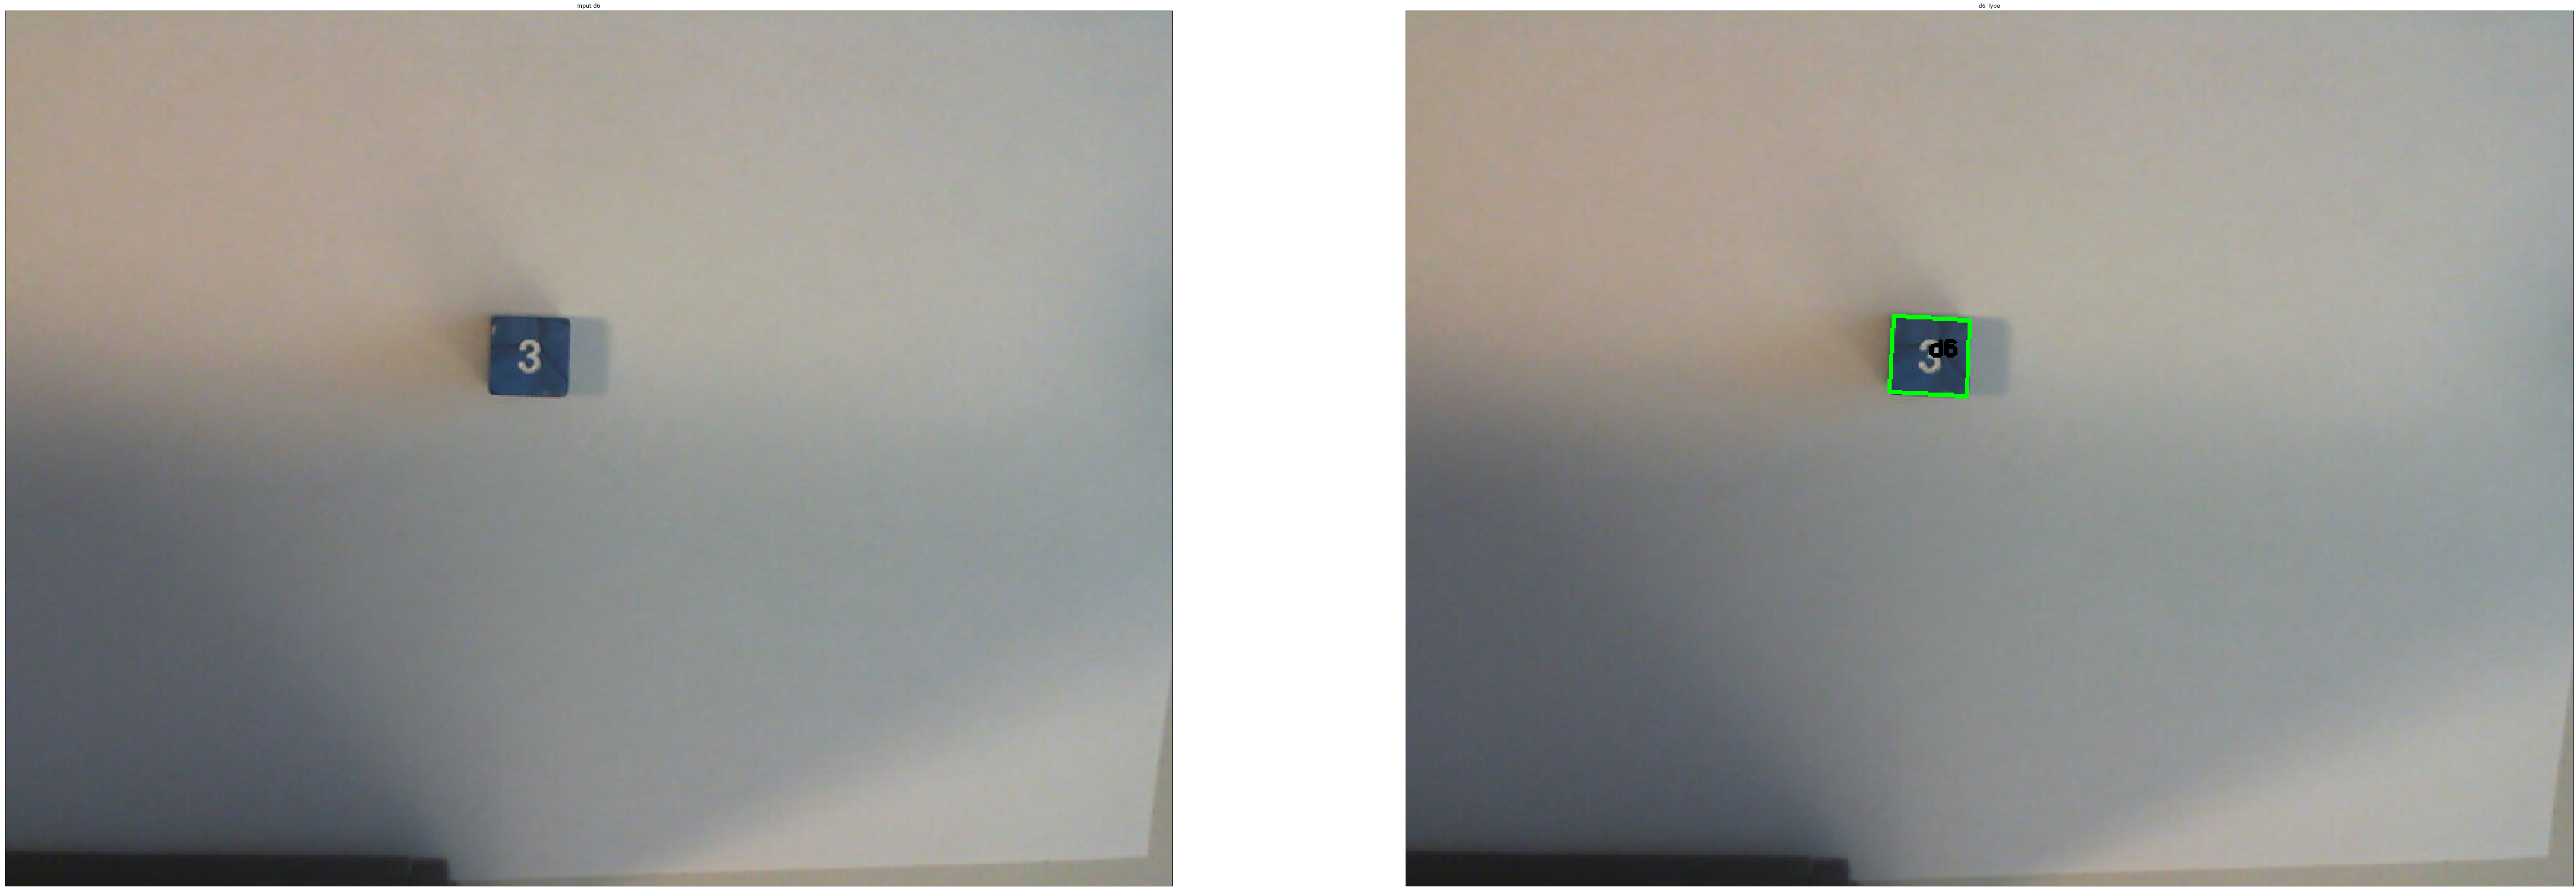

In [5]:
d12RGB = cv2.cvtColor(d12, cv2.COLOR_BGR2RGB)
d12TypeRGB = cv2.cvtColor(d12Type, cv2.COLOR_BGR2RGB)
d6RGB = cv2.cvtColor(d6, cv2.COLOR_BGR2RGB)
d6TypeRGB = cv2.cvtColor(d6Type, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(100,100))
plt.subplot(121), plt.imshow(d12RGB), plt.title("Input d12"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(d12TypeRGB), plt.title("d12 Type"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(100,100))
plt.subplot(221), plt.imshow(d6RGB), plt.title("Input d6"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(d6TypeRGB), plt.title("d6 Type"), plt.xticks([]), plt.yticks([])

By identifying the type of die before reading the number off of it, this gives a range for the expected value. This will provide help when trying to identify a potentially 2 digit number from a d10, d12, d20, or d% as compared to a 1 digit number from a d4, d6, or d8. 

I am still currently unsure if it will be possible to identify a d4 other as the number on a d4 is usually at the top of the die and thus unviewable.

#### Next Steps

Proceeding forward I need to make adjustments to the realtime filtering so that it only tries to classify dice once after movement has stopped after being rolled. 

I also want to look into Hough Circle Transforms to see if there is a more efficient way to filter dice to achieve a smoother result.

In addition, after the dice have been identified I need to process the text on the dice and sum the results. I plan to try text recognition with Tesseract. Depending on how this works, I may switch to using the Google Cloud API. However, as this has to be run on the Google Cloud platform I want to try and avoid that if possible.

In summary, my next goals are:
* Filter realtime video
* Change video so that it only filters dice after they have been rolled
* Identify dice type from video 
* Read number off of the identified dice
* Sum numbers of rolled dice